# QAOA Braket

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings import TimeSeries
from braket.ahs.driving_field import DrivingField
from collections import defaultdict


from braket.aws import AwsDevice
from braket.aws import  AwsQuantumTask
from braket.task_result.task_metadata_v1 import TaskMetadata


from quera_ahs_utils.plotting import (
    show_global_drive,
    show_register,
    show_register
)


import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import networkx as nx
import itertools

from pprint import pprint as pp

from docplex.mp.model import Model

from braket.devices import LocalSimulator

import json


In [2]:
backends = {}
backends["Aquila"] = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
backends["Emulator"] = LocalSimulator("braket_ahs")

## Definitions

In [7]:
with open("./Data/problems.json", "r") as file:
    problems = json.load(file)

#### Register

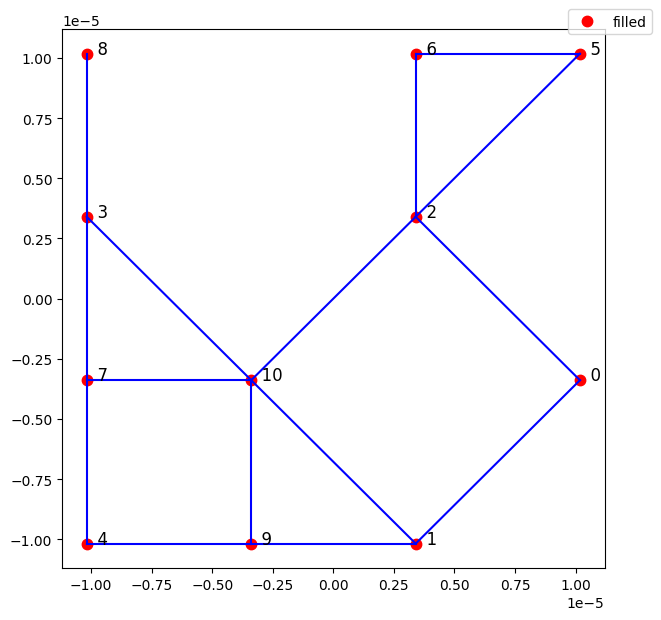

In [14]:
nq = 11
with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
problem.keys()
register = AtomArrangement()
a = 6.79e-6
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    register.add([round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)])    

show_register(register, blockade_radius = np.sqrt(2)*a)

#### Schedule

In [24]:
with open("./Data/opt_schedule.json", "r") as file:
    schedule = json.load(file)

omegas = [0,0] + [i for i in schedule["omega_list"] for _ in range(2)] + [0]
deltas = [0,0] + [i for i in schedule["delta_list"] for _ in range(2)] + [0]
phis = len(omegas) * [0]
num_pulses = len(schedule["omega_list"])

t_tot = 2.0e-6
t_q = 0.052e-6
t_p = t_tot/num_pulses-t_q
t_delay = round(1.95e-6,9)
times = [0 , t_delay]
t_i = t_delay
for i in range(0, num_pulses):
    t_i += round(t_q,9)
    times.append(t_i)
    t_i += round(t_p,9)
    times.append(t_i)
times.append(round(t_i+t_p,9))

Omega = TimeSeries.from_lists(times, omegas)
Delta = TimeSeries.from_lists(times, deltas)
phi = TimeSeries.from_lists(times, phis)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta
)

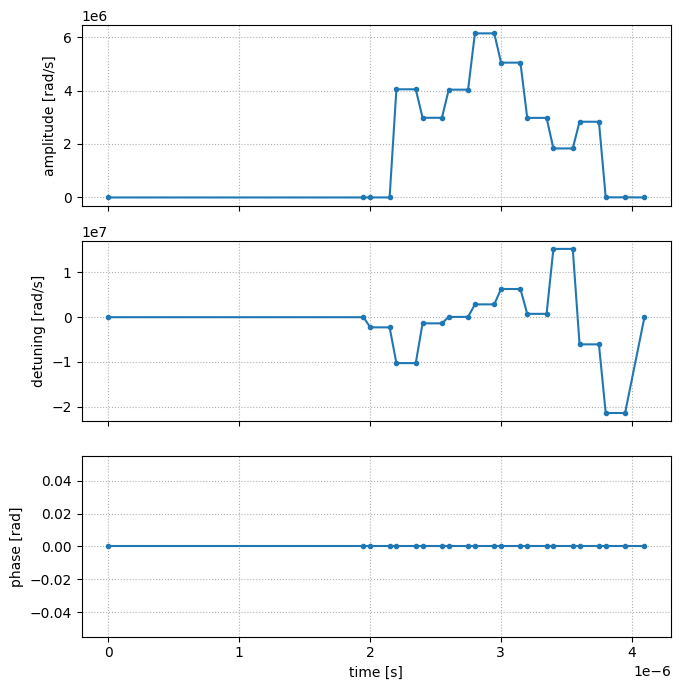

In [25]:
show_global_drive(drive)

#### Evolution

##### Ideal

In [31]:
shots = 200

H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)
H += drive


In [32]:
result = {}
backend_name = "Emulator"
job = backends[backend_name].run(ahs_program, shots=shots)
if backend_name == "Emulator":
    res = job.result()
    dict_counts = defaultdict(int)
    for k, count in res.get_counts().items():
        dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
    result["samples"] = dict_counts
elif backend_name == "Aquila":
    arn = job.id
    result['arn'] = arn
np.save(f"./Data/{backend_name}/{nq}.npy", result)


In [ ]:
# backend_name = "Aquila"
# nq = 10
if backend_name == "Aquila":
    result = np.load(f"./Data/{backend_name}/{nq}.npy", allow_pickle=True).item()
    arn = result['arn']
    res = AwsQuantumTask(arn = arn).result()
    dict_counts = defaultdict(int)
    for k, count in res.get_counts().items():
        dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
    result["samples"] = dict_counts
    

KeyboardInterrupt: 

In [20]:
max_independent_set = brute_force_maximum_independent_set(small_G)
MIS_size_sol = len(max_independent_set)

loaded_graph = small_G

dict_probs = {}
succ_prob = 0.

for sol in list(dict_results_emu.keys()):    
    # Extract indices of '1' in the bitstring
    sol_reverse = sol[::1]
    node_set_indices = [i for i, bit in enumerate(sol_reverse) if bit == '1']
    prob = dict_results_emu[sol]/shots
    dict_probs[sol_reverse] = prob

    # Create a node set from the selected indices
    node_set = set(node_set_indices)
    if sol_reverse.count('1') == MIS_size_sol and is_independent_set(loaded_graph,node_set):
        succ_prob += prob
        
sorted_keys = sorted(dict_probs, key=dict_probs.get, reverse=True)
sorted_dict = {k: dict_probs[k] for k in sorted_keys}
dict_probs = sorted_dict

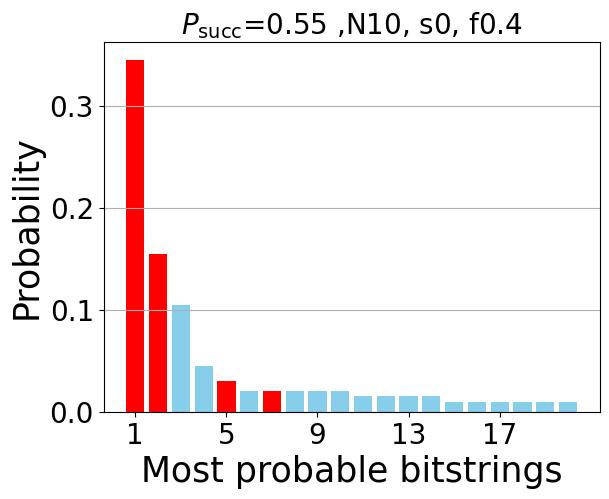

In [21]:
seed_list = [seed]
filling_list = [filling]

# Number of rows and columns
n_rows = len(seed_list)
n_cols = len(filling_list)

#fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols,4*n_rows), sharex=False, sharey=False)
fig,axes = plt.subplots()

for i,seed in enumerate(seed_list):
    for j,filling in enumerate(filling_list):

        if n_rows == 1 and n_cols == 1:
            ax = axes
        elif n_rows == 1:
            ax = axes[j]
        elif n_cols == 1:
            ax = axes[i]
        else:
            ax = axes[i, j]
            
        pos, small_G, distances = kings_graph(numx, numy, filling, seed)
        max_independent_set = brute_force_maximum_independent_set(small_G)
        MIS_size_sol = len(max_independent_set)
        
        N = len(distances)

        #prob = dict_final_H_high_probs[omega_m][delta_f][delta_i][t_sweep]
        prob = dict_probs

        num_hystos = 20

        bitstrings = list(prob.keys())[::1][:num_hystos]
        prob_values = list(prob.values())[::1][:num_hystos]

        #ax = axes[idx]
        ax.bar(bitstrings, prob_values, color='skyblue')

        succ_prob = succ_prob
        ax.set_title(r'$P_{\mathrm{succ}}$'+f'={succ_prob:.2f} ,N{N}, s{seed}, f{filling}', fontsize=20)
        ax.tick_params(axis='x',labelsize=20)
        ax.grid(axis='y')
        #ax.set_xticks(list(range(num_hystos)))
        # Specify the tick positions and labels
        tick_positions = list(range(0,num_hystos,4))  # Positions to place the ticks
        tick_labels = [f"{pos+1}" for pos in tick_positions]  # Format labels
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.tick_params(axis='y',labelsize=20)
        
        if j == 0: 
            ax.set_ylabel('Probability', fontsize=25)
            #ax.set_yticks(y_values[::3])
            
        if i == n_rows-1:
            ax.set_xlabel('Most probable bitstrings', fontsize=25)
            
        # if j == n_cols -1 and i == n_rows//2: 
        #     cbar.set_label(r"$\langle {\hat{n}}_i \rangle$",fontsize = 24)

        for k, sol in enumerate(bitstrings):
            #sol = sol[::-1]
            node_set_indices = [k for k, bit in enumerate(sol) if bit == '1']
            node_set = set(node_set_indices)

            if is_independent_set(small_G, node_set) and sol.count('1') == MIS_size_sol:
                ax.get_children()[k].set_facecolor('red')

plt.subplots_adjust(wspace=0.4, hspace=0.4)  # You can adjust these values as needed

#plt.suptitle(f't = {t_tot:.2f}, p= {p}, {fields_shape}, {optimal_params_behavior}', fontsize=24,y=0.97)
#plt.suptitle(f"{fields_shape}, {optimal_params_behavior}, t_tot {t_tot}",fontsize=30,y=1.03)
#plt.savefig(f'./Plots/final_H_high_probs_t{t_tot:.2f}_p{p}_xy{numx}-{numy}_s{seed_list[0]}-{seed_list[-1]}_f{filling_list[0]}-{filling_list[-1]}_{fields_shape}_{optimal_params_behavior}.png',bbox_inches='tight')

plt.show()
plt.close()

## Multiple Graphs

### Braket Emulator

In [7]:
proc_unit = 'Emu_Braket'

#### Registers

In [8]:
a = 6.78806e-6

lattice = 'graph'

grid_side_list = [5]
seed_list = [5]
filling_list = [0.4,0.45,0.5]

dict_qaoa_graph = {}

for grid_side in grid_side_list:
    dict_qaoa_graph[f'grid_side {grid_side}'] = {}
    for seed in seed_list:
        dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'] = {}
        for filling in filling_list:
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}'] = {}
            
            register = AtomArrangement()

            numx,numy = [grid_side,grid_side]

            # Make a small king's graph
            pos, small_G, distances = kings_graph(numx, numy, filling, seed)
            N = len(distances)
            print('N', N)
            # print('small G', small_G)

            x_shift = a * (numx - 1) / 2
            y_shift = a * (numy - 1) / 2
            pos_dict = {}
            for i, pos_i in enumerate(pos):
                pos_dict[f"q{i}"] = [pos_i[0] * a - x_shift, pos_i[1] * a - y_shift]

            for key in pos_dict.keys():
                #print(x)
                register.add(pos_dict[key])
                
            #show_register(register, blockade_radius = np.sqrt(2)*a)
                
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['register'] = register
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['graph'] = small_G

N 10
N 11
N 12


#### Schedules

In [9]:
C6 = 5.42e-24
UNN = C6/a**6

p = 10

omega_opt_list = np.array([0.0013533659033773317,
 4.045866754699931,
 2.9797945552295904,
 4.031646387060219,
 6.13680201056113,
 5.042842461864641,
 2.9761309901447177,
 1.8335073028710545,
 2.8312315456027655,
 0.005323555828519899])*1e6
delta_opt_list = np.array([-2.2705852238763873,
 -10.267156003603997,
 -1.37474817026258,
 0.0644988201504712,
 2.869285157654999,
 6.309152585006643,
 0.7500851533315123,
 15.27993355344018,
 -6.074855874393538,
 -21.428780809189433])*1e6


t_tot = 2.0e-6
t_q = 0.052e-6
t_p = t_tot/p-t_q
t_step = t_q+t_p
t_delay = 1.95e-6

Omega = TimeSeries()
Delta = TimeSeries()
phi = TimeSeries()

Omega.put(0.,0.0).put(t_delay,0.0)#.put(t_delay+t_q,omega_opt_list[0]).put(t_p,omega_opt_list[0])
Delta.put(0.,0.0).put(t_delay,0.0)#.put(t_q,delta_opt_list[0]).put(t_p,delta_opt_list[0])
phi.put(0.,0.0).put(t_delay,0.)#.put(t_q,0.).put(t_p,0.)

t_i = t_delay

for i in range(0,p):
    t_i += t_q
    Omega.put(t_i,omega_opt_list[i])
    Delta.put(t_i,delta_opt_list[i])
    phi.put(t_i,0.)
    t_i += t_p
    Omega.put(t_i,omega_opt_list[i])
    Delta.put(t_i,delta_opt_list[i])
    phi.put(t_i,0.)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta
)

#### Evolution

##### Ideal

In [11]:
shots = 200

H = Hamiltonian()

H += drive

In [12]:
for grid_side in grid_side_list:
    for seed in seed_list:
        for filling in filling_list:
            
            register = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['register']
            
            ahs_program = AnalogHamiltonianSimulation(
            hamiltonian=H,
            register=register
            )

            result = simulator.run(ahs_program, shots=shots).result()
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['results'] = result
            
np.save(f"./Results/results_qaoa_N{N}_sam{shots}_{lattice}_{proc_unit}.npy", dict_qaoa_graph)
print('done')

done


In [14]:
result_sim = np.load(f"./Results/results_qaoa_N{N}_sam{shots}_{lattice}_{proc_unit}.npy",allow_pickle=True).item()

for grid_side in grid_side_list:
    for seed in seed_list:
        for filling in filling_list:           

            dict_counts = {}
            for k, count in result_sim[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['results'].get_counts().items():
                dict_counts["".join("1" if s == "r" else "0" for s in k)] = 0
                dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['counts'] = dict_counts
            #dict_results[f'Omega_1 {Omega_1}'][f'time_step {time_step}']['counts'] = dict_counts

In [15]:
for grid_side in grid_side_list:
    for seed in seed_list:
        for filling in filling_list:

            small_G = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['graph']
            dict_results_emu = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['counts']

            max_independent_set = brute_force_maximum_independent_set(small_G)
            MIS_size_sol = len(max_independent_set)

            loaded_graph = small_G

            dict_probs = {}
            succ_prob = 0.

            for sol in list(dict_results_emu.keys()):    
                # Extract indices of '1' in the bitstring
                sol_reverse = sol[::1]
                node_set_indices = [i for i, bit in enumerate(sol_reverse) if bit == '1']
                prob = dict_results_emu[sol]/shots
                dict_probs[sol_reverse] = prob

                # Create a node set from the selected indices
                node_set = set(node_set_indices)
                if sol_reverse.count('1') == MIS_size_sol and is_independent_set(loaded_graph,node_set):
                    succ_prob += prob

            sorted_keys = sorted(dict_probs, key=dict_probs.get, reverse=True)
            sorted_dict = {k: dict_probs[k] for k in sorted_keys}
            dict_probs = sorted_dict
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['dict_probs'] = dict_probs
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['succ_prob'] = succ_prob

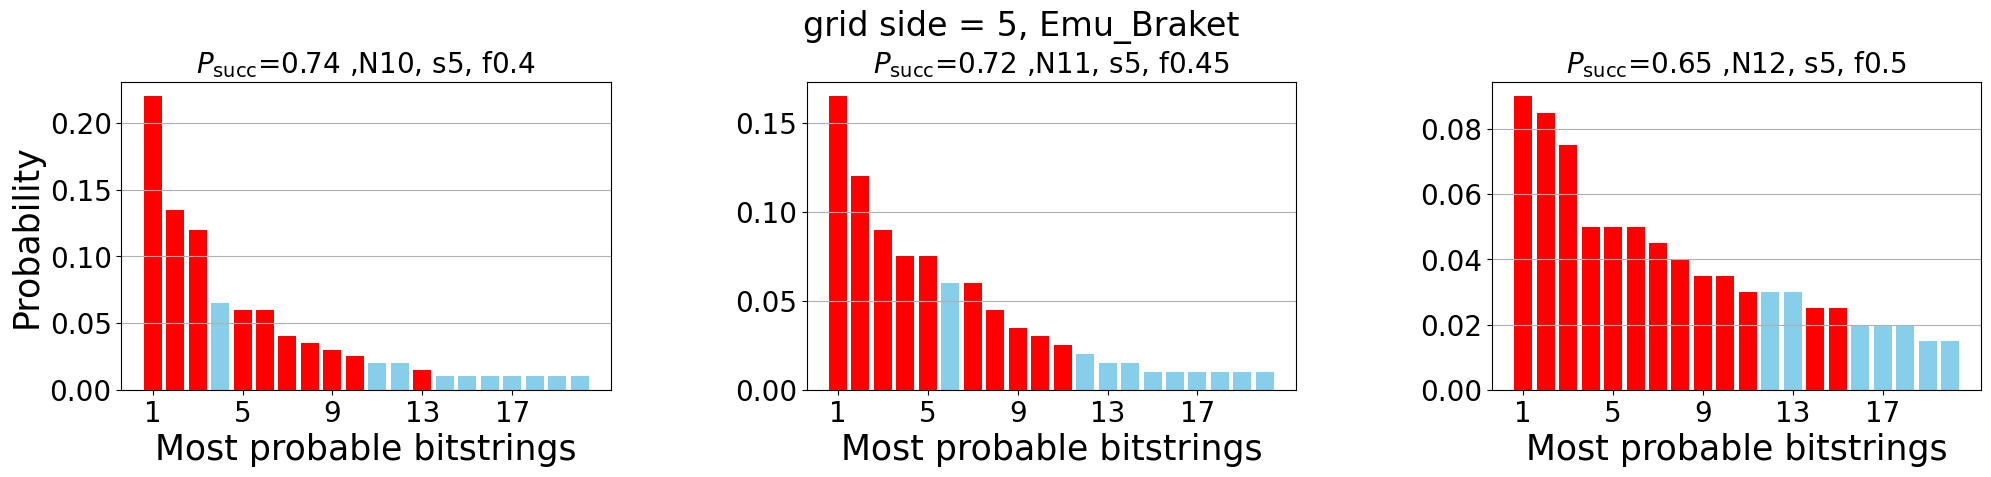

In [18]:
# Number of rows and columns
n_rows = len(seed_list)
n_cols = len(filling_list)


for grid_side in grid_side_list:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols,4*n_rows), sharex=False, sharey=False)

    for i,seed in enumerate(seed_list):
        for j,filling in enumerate(filling_list):

            if n_rows == 1 and n_cols == 1:
                ax = axes
            elif n_rows == 1:
                ax = axes[j]
            elif n_cols == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            small_G = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['graph']
            max_independent_set = brute_force_maximum_independent_set(small_G)
            MIS_size_sol = len(max_independent_set)

            N = len(small_G.nodes())

            #prob = dict_final_H_high_probs[omega_m][delta_f][delta_i][t_sweep]
            prob = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['dict_probs']

            num_hystos = 20

            bitstrings = list(prob.keys())[::1][:num_hystos]
            prob_values = list(prob.values())[::1][:num_hystos]

            #ax = axes[idx]
            ax.bar(bitstrings, prob_values, color='skyblue')

            succ_prob = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['succ_prob']

            ax.set_title(r'$P_{\mathrm{succ}}$'+f'={succ_prob:.2f} ,N{N}, s{seed}, f{filling}', fontsize=20)
            ax.tick_params(axis='x',labelsize=20)
            ax.grid(axis='y')
            #ax.set_xticks(list(range(num_hystos)))
            # Specify the tick positions and labels
            tick_positions = list(range(0,num_hystos,4))  # Positions to place the ticks
            tick_labels = [f"{pos+1}" for pos in tick_positions]  # Format labels
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels)
            ax.tick_params(axis='y',labelsize=20)

            if j == 0: 
                ax.set_ylabel('Probability', fontsize=25)
                #ax.set_yticks(y_values[::3])

            if i == n_rows-1:
                ax.set_xlabel('Most probable bitstrings', fontsize=25)

            # if j == n_cols -1 and i == n_rows//2: 
            #     cbar.set_label(r"$\langle {\hat{n}}_i \rangle$",fontsize = 24)

            for k, sol in enumerate(bitstrings):
                #sol = sol[::-1]
                node_set_indices = [k for k, bit in enumerate(sol) if bit == '1']
                node_set = set(node_set_indices)

                if is_independent_set(small_G, node_set) and sol.count('1') == MIS_size_sol:
                    ax.get_children()[k].set_facecolor('red')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # You can adjust these values as needed

    plt.suptitle(f'grid side = {grid_side}, {proc_unit}', fontsize=24,y=1.06)
#plt.suptitle(f"{fields_shape}, {optimal_params_behavior}, t_tot {t_tot}",fontsize=30,y=1.03)
#plt.savefig(f'./Plots/final_H_high_probs_t{t_tot:.2f}_p{p}_xy{numx}-{numy}_s{seed_list[0]}-{seed_list[-1]}_f{filling_list[0]}-{filling_list[-1]}_{fields_shape}_{proc_unit}.png',bbox_inches='tight')

plt.show()
plt.close()

### Real Device

In [10]:
proc_unit = 'Aquila'

#### Registers

In [11]:
a = 6.78806e-6

lattice = 'graph'

grid_side_list = [5,6,7,8,9]
seed_list = [0,1,2]
filling_list = [0.7,0.85]

dict_qaoa_graph = {}

for grid_side in grid_side_list:
    dict_qaoa_graph[f'grid_side {grid_side}'] = {}
    for seed in seed_list:
        dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'] = {}
        for filling in filling_list:
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}'] = {}
            
            register = AtomArrangement()

            numx,numy = [grid_side,grid_side]

            # Make a small king's graph
            pos, small_G, distances = kings_graph(numx, numy, filling, seed)
            N = len(distances)
            print('N', N)
            # print('small G', small_G)

            x_shift = a * (numx - 1) / 2
            y_shift = a * (numy - 1) / 2
            pos_dict = {}
            for i, pos_i in enumerate(pos):
                pos_dict[f"q{i}"] = [pos_i[0] * a - x_shift, pos_i[1] * a - y_shift]

            for key in pos_dict.keys():
                #print(x)
                register.add(pos_dict[key])
                
            #show_register(register, blockade_radius = np.sqrt(2)*a)
                
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['register'] = register
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['graph'] = small_G
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['N'] = N

N 17
N 21
N 17
N 21
N 17
N 21
N 25
N 30
N 25
N 30
N 25
N 30
N 34
N 41
N 34
N 41
N 34
N 41
N 44
N 54
N 44
N 54
N 44
N 54
N 56
N 68
N 56
N 68
N 56
N 68


#### Schedules

In [12]:
C6 = 5.42e-24
UNN = C6/a**6

p = 10

omega_opt_list = np.array([0.0013533659033773317,
 4.045866754699931,
 2.9797945552295904,
 4.031646387060219,
 6.13680201056113,
 5.042842461864641,
 2.9761309901447177,
 1.8335073028710545,
 2.8312315456027655,
 0.005323555828519899])*1e6
delta_opt_list = np.array([-2.2705852238763873,
 -10.267156003603997,
 -1.37474817026258,
 0.0644988201504712,
 2.869285157654999,
 6.309152585006643,
 0.7500851533315123,
 15.27993355344018,
 -6.074855874393538,
 -21.428780809189433])*1e6


t_tot = 2.0e-6
t_q = 0.052e-6
t_p = t_tot/p-t_q
t_step = t_q+t_p
t_delay = 1.95e-6

Omega = TimeSeries()
Delta = TimeSeries()
phi = TimeSeries()

Omega.put(0.,0.0).put(t_delay,0.0)#.put(t_delay+t_q,omega_opt_list[0]).put(t_p,omega_opt_list[0])
Delta.put(0.,0.0).put(t_delay,0.0)#.put(t_q,delta_opt_list[0]).put(t_p,delta_opt_list[0])
phi.put(0.,0.0).put(t_delay,0.)#.put(t_q,0.).put(t_p,0.)

t_i = t_delay

for i in range(0,p):
    t_i += t_q
    Omega.put(t_i,omega_opt_list[i])
    Delta.put(t_i,delta_opt_list[i])
    phi.put(t_i,0.)
    t_i += t_p
    Omega.put(t_i,omega_opt_list[i])
    Delta.put(t_i,delta_opt_list[i])
    phi.put(t_i,0.)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta
)

#### Evolution

In [13]:
H = Hamiltonian()

H += drive

In [12]:
for grid_side in grid_side_list:
    for seed in seed_list:
        for filling in filling_list:
            
            register = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['register']
            
            N = dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['N']
            
            if N < 21:
                shots = 200
            if 20 < N and N < 41:
                shots = 400
            if 40 < N  and N < 61:
                shots = 600
            if 60 < N and N < 81:
                shots = 800
                
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['shots'] = shots
            
            ahs_program = AnalogHamiltonianSimulation(
            hamiltonian=H,
            register=register
            )

            result = simulator.run(ahs_program, shots=shots).result()
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['results'] = result
            
np.save(f"./Results/results_qaoa_{lattice}_{proc_unit}.npy", dict_qaoa_graph)
print('done')

done


In [14]:
result_sim = np.load(f"./Results/results_qaoa_{lattice}_{proc_unit}.npy",allow_pickle=True).item()

for grid_side in grid_side_list:
    for seed in seed_list:
        for filling in filling_list:           

            dict_counts = {}
            for k, count in result_sim[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['results'].get_counts().items():
                dict_counts["".join("1" if s == "r" else "0" for s in k)] = 0
                dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
            dict_qaoa_graph[f'grid_side {grid_side}'][f'seed {seed}'][f'filling {filling}']['counts'] = dict_counts
            #dict_results[f'Omega_1 {Omega_1}'][f'time_step {time_step}']['counts'] = dict_counts